# PS3

In [116]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')
incomes = np.loadtxt('incomes.txt')

 ### (a) Plota histogram of income.txt with 30 bins.

In [117]:
incomes = pd.read_csv("incomes.txt", header = None)
incomes.rename(columns={0: 'Income'}, inplace=True)

<IPython.core.display.Javascript object>


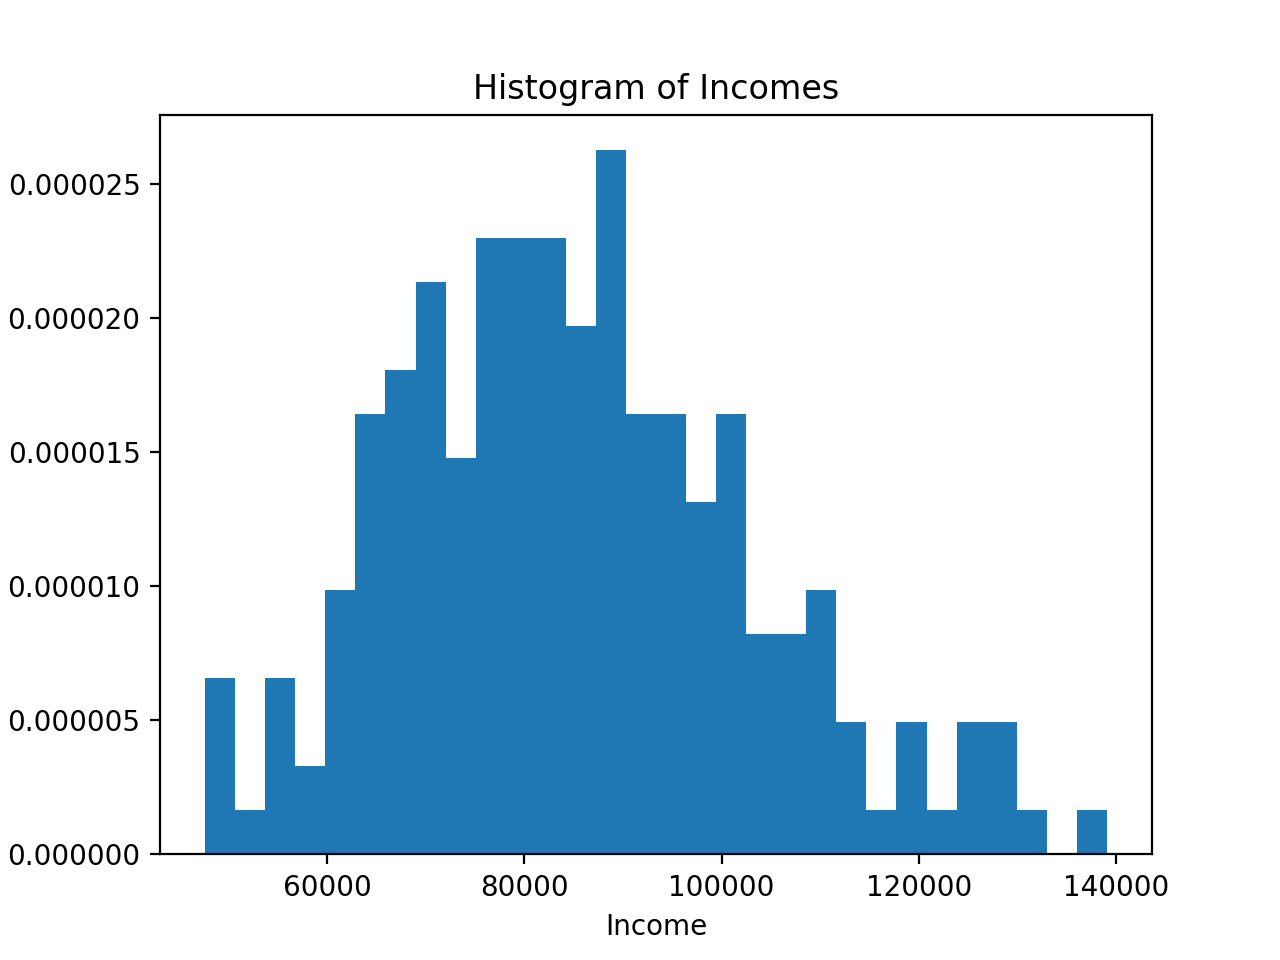

In [118]:
plt.hist(incomes["Income"], bins = 30, normed=True)
plt.ylabel("Normed Count")
plt.xlabel("Income")
plt.title("Histogram of Incomes")
plt.show()

### (b) Estimate lognormal parameters using GMM. Using avg income, and std. dev. of income as two momemnts. Let $\hat{\textbf{W}} = \textbf{I}$. Plot estimated pdf against histogram.

In [119]:
# PDF of log norm
def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the log normal pdf with mean mu and
    standard deviation sigma. 
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the log normally distributed random variable
    sigma  = scalar > 0, standard deviation of the log normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:

    pdf_vals = (N,) vector, log normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
            
    pdf_vals    = (1/(xvals * sigma * np.sqrt(2 * np.pi) ) *
                   np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

Now let's define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix  Ŵ W^ .

In [120]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    sd_data = np.sqrt(xvals.var())
  
    return mean_data, sd_data

def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    
    mean_model = np.exp(mu + sigma ** 2 / 2)
    var_model = np.exp(2 * mu + sigma ** 2) * (np.exp(sigma ** 2) - 1)  
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model

def err_vec(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])

    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec



def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


Now we can perform the GMM estimation. Let's start with the identity matrix as our estimate for the optimal weighting matrix  W=IW=I .

In [121]:
mu = np.log(incomes["Income"].values).mean()
sigma = np.sqrt(np.log(incomes["Income"].values).var())
params = np.array([mu, sd])
results = minimize(criterion, params, args=(incomes["Income"].values, np.eye(2)), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

In [122]:
results.x

array([ 11.33188484,   0.20869633])

#### Plot the estimated GMM PDF

<IPython.core.display.Javascript object>


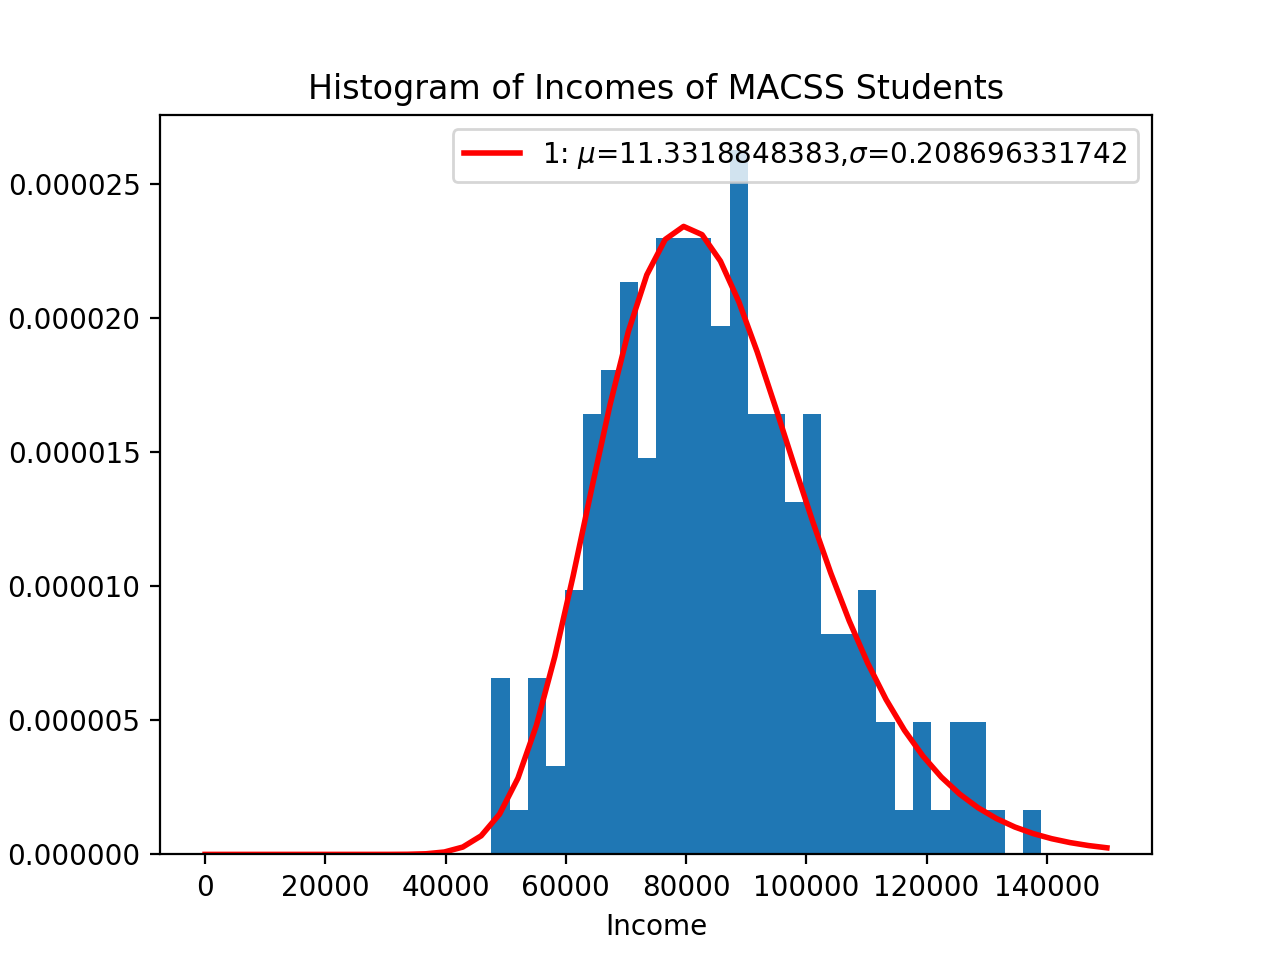

In [123]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='1: $\mu$='+str(res.x[0])+',$\sigma$='+str(res.x[1]))
plt.ylabel("Normed Count")
plt.xlabel("Income")
plt.title("Histogram of Incomes of MACSS Students")
plt.legend()
plt.show()

In [124]:
gmm_b_mu, gmm_b_sd = res.x
mean_data, sd_data = data_moments(incomes["Income"])
mean_model, sd_model = model_moments(res.x[0], res.x[1])
err = errs(incomes["Income"], res.x[0], res.x[1]).reshape(2,)
print('Data Mean  =', mean_data, ', Data SD =', sd_data)
print('Model Mean =', mean_model, ', Model SD =', sd_model)
print('Error vector=', err)
print('Crit. Function Value= ', res.fun[0])
results

Data Mean  = 85276.82360625808 , Data SD = 18037.6928694
Model Mean = 85277.1583751 , Model SD = 17992.5836974
Error vector= [ -3.92567258e-06   2.50082825e-03]
Crit. Function Value=  [  2.07487051e-11]


      fun: array([[  2.07487051e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.24921238e-05,   2.54906503e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([ 11.33188484,   0.20869633])

### c) Two step GMM.

Let's first try the two-step weighting matrix.

In [125]:
err1 = errs(incomes["Income"], res.x[0], res.x[1])
VCV = np.dot(err1, err1.T) / incomes["Income"].shape[0]
W = la.pinv(VCV) 
params = np.array([res.x[0], res.x[1]])
results = minimize(criterion, params, args=(incomes["Income"], W),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

In [126]:
mean_data, sd_data = data_moments(incomes["Income"])
mean_model, sd_model = model_moments(res.x[0], res.x[1])
err = errs(incomes["Income"], res.x[0], res.x[1]).reshape(2,)
print('Data Mean  =', mean_data, ', Data sd =', sd_data)
print('Model Mean =', mean_model, ', Model sd =', sd_model)
print('Error vector=', err)
print('Crit. Function Value= ', res.fun[0])
res

Data Mean  = 85276.82360625808 , Data sd = 18037.6928694
Model Mean = 85277.1583751 , Model sd = 17992.5836974
Error vector= [ -3.92567258e-06   2.50082825e-03]
Crit. Function Value=  [  2.07487051e-11]


      fun: array([[  2.07487051e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.24921238e-05,   2.54906503e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([ 11.33188484,   0.20869633])

Plot the estimated GMM

<IPython.core.display.Javascript object>


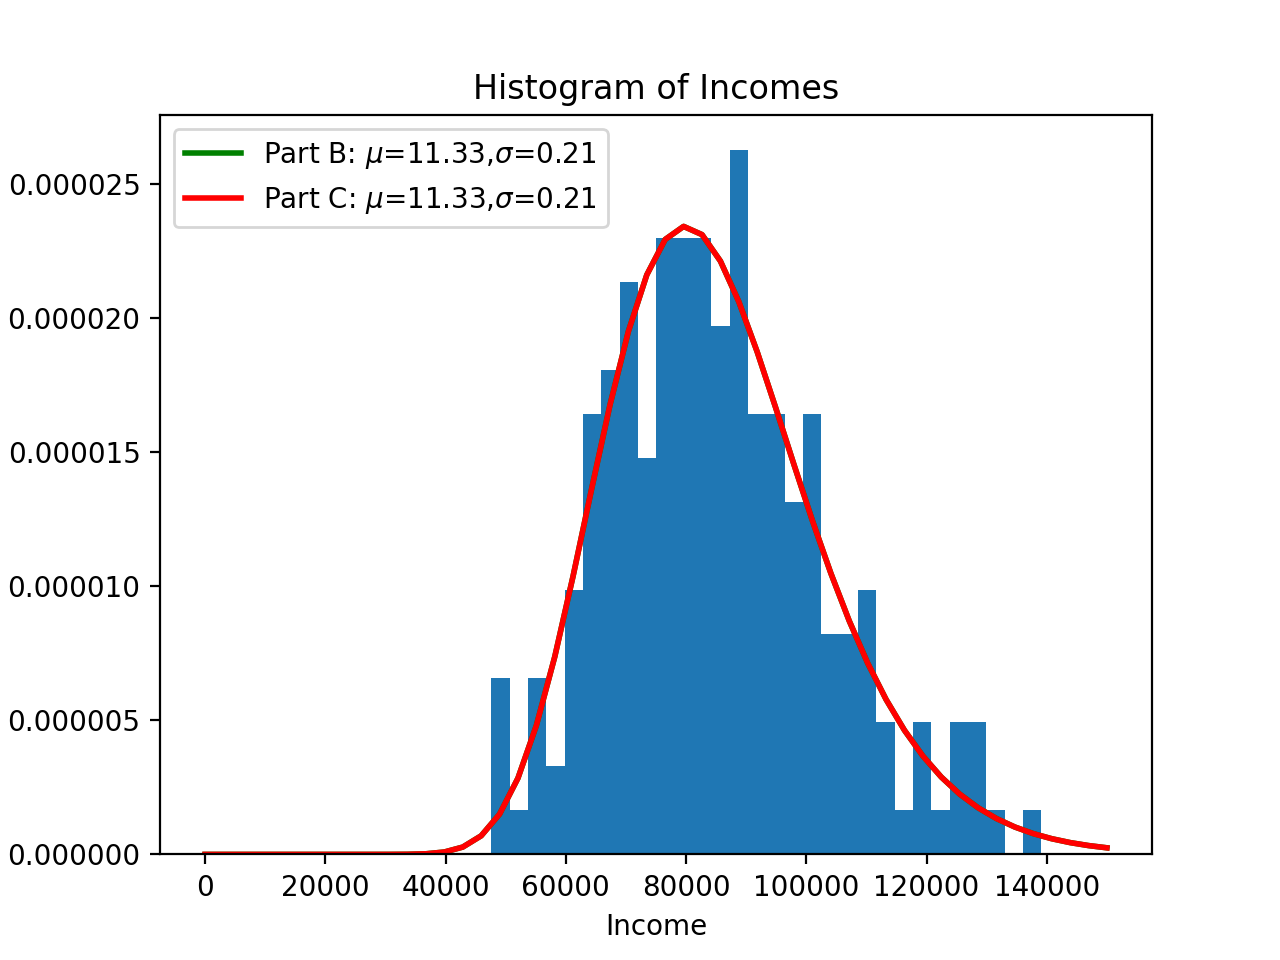

In [127]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_sd),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_sd.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income")
plt.title("Histogram of Incomes")
plt.legend()
plt.show()

the estmated GMM parameter values are $\mu = 11.331$ and $\text{sd} = 0.0208$. The data moments and model moments listed above are very simmilar.   
Our error vectors are quite small but there is a larger gap in SD.The value of the crit function is same as part b, $2.07487051E-11$. 

#### (d) Using percent of individuals who earn less than $75,000, between $75,000 and \$100,000 and more than $100,000 as moments.

In [145]:
def new_data_moments(x):
    N = len(x)
    i = np.array(x)
    m_un = sum(i < 75000)/N
    m_bet = np.all((i >= 75000, i <= 100000), axis = 0).sum()/N
    m_up = sum(i > 100000)/N
    
    return m_un, m_bet, m_up

def cdf_LN(x, mu, sd):
    return integrate.quad(lambda x: log_norm(x, mu, sd), 1e-10, x)

def new_model_moments(mu, sd):
    m_un = cdf_LN(75000, mu, sd)[0]
    m_bet = cdf_LN(100000, mu, sd)[0] - m_un
    m_up = 1 - cdf_LN(100000, mu, sd)[0]
    return m_un, m_bet, m_up

def new_errs(x, mu, sd):
    md = np.array(new_data_moments(x)).reshape((3,1))
    mm = np.array(new_model_moments(mu, sd)).reshape((3,1))
    return (md - mm)/md

def new_criterion(params, *args):
    mu, sd = params
    x, W = args 
    err = new_errs(x, mu, sd)
    return err.T @ W @ err

In [147]:
params = np.array([11, 0.5])
resd = minimize(new_criterion, params, args=(incomes["Income"].values, np.eye(3)), method='L-BFGS-B', bounds=((None, None), (0.001, None)))
resd.x

array([ 11.33568132,   0.21059845])

This time, the result is different. Model and data moments are very close. Error values are larger, so these moments are not as effetcive. Additionally, the mu and sigma are slightly different. 

<IPython.core.display.Javascript object>


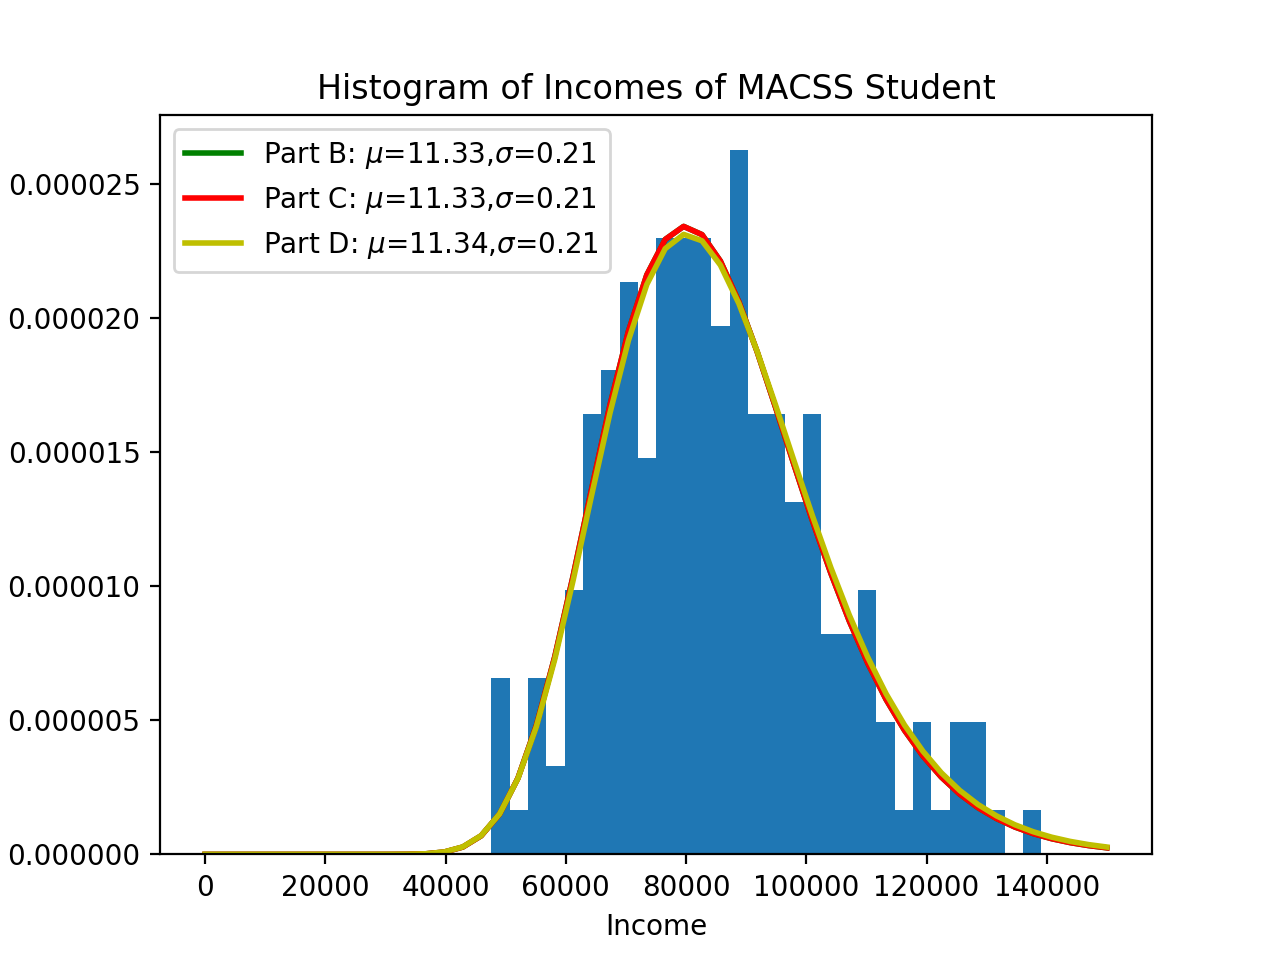

In [151]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_sd),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_sd.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.plot(x, log_norm(x, resd.x[0], resd.x[1]),
         linewidth=2, color='y', label='Part D: $\mu$='+ str(resd.x[0].round(2))+',$\sigma$='+ str(resd.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income")
plt.title("Histogram of Incomes of MACSS Student")
plt.legend()
plt.show()

#### (e) Two step of (d).

In [43]:
errd = new_errs(incomes["Income"], resd.x[0], resd.x[1])
VCV = np.dot(errd, errd.T) / incomes["Income"].shape[0]
W = la.pinv(VCV) 
params = np.array([resd.x[0], resd.x[1]])
results_e = minimize(new_criterion, params, args=(incomes["Income"], W),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

In [44]:
under, between, over = new_data_moments(incomes["Income"])
under_model, between_model, over_model = new_model_moments(results_e.x[0], results_e.x[1])
err = errs(incomes["Income"], results_e.x[0], results_e.x[1]).reshape(2,)
print('Data: Under 75:  =', under, ', Data Between 75-100 =', between, ', Over 100k = ',over)
print('Data: Under 75:  =', under_model, ', Data Between 75-100 =', between_model, ', Over 100k = ',over_model)
print('Error vector=', err)
print('Crit. Function Value= ', results_e.fun[0])
results_e

Data: Under 75:  = 0.3 , Data Between 75-100 = 0.5 , Over 100k =  0.2
Data: Under 75:  = 0.300000001224124 , Data Between 75-100 = 0.49999999921764343 , Over 100k =  0.19999999955823256
Error vector= [-0.00420802 -0.01102553]
Crit. Function Value=  [ 0.24316761]


      fun: array([[ 0.24316761]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.58277943e+10,   7.32154254e+09])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 138
      nit: 2
   status: 2
  success: False
        x: array([ 11.33568133,   0.21059846])

<IPython.core.display.Javascript object>


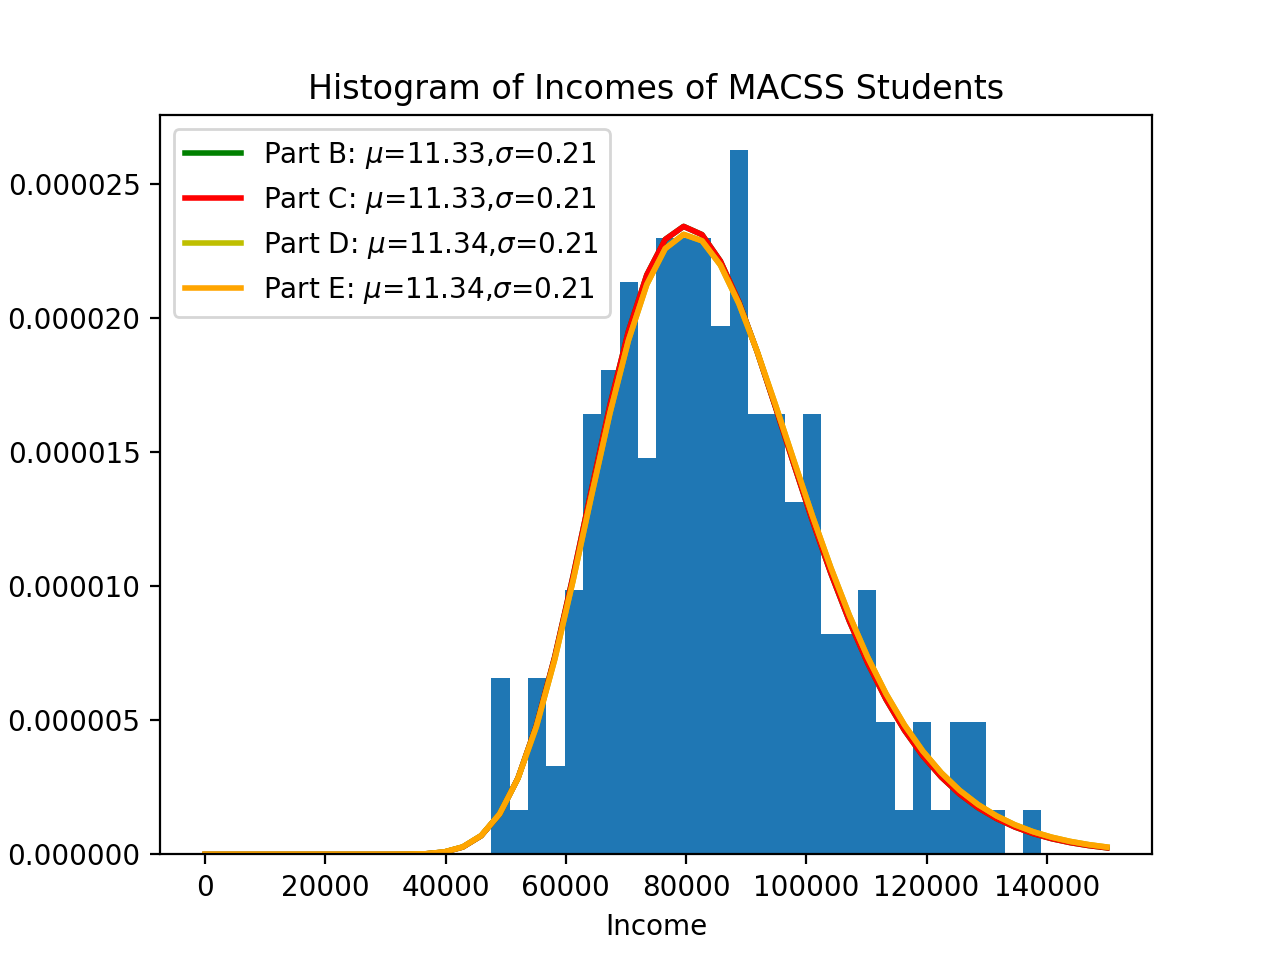

In [152]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_sd),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_sd.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.plot(x, log_norm(x, resd.x[0], resd.x[1]),
         linewidth=2, color='y', label='Part D: $\mu$='+ str(resd.x[0].round(2))+',$\sigma$='+ str(resd.x[1].round(2)))
plt.plot(x, log_norm(x, results_e.x[0], results_e.x[1]),
         linewidth=2, color='orange', label='Part E: $\mu$='+ str(results_e.x[0].round(2))+',$\sigma$='+ str(results_e.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income")
plt.title("Histogram of Incomes of MACSS Students")
plt.legend()
plt.show()

Results are the same as the previous part. Model and data moments are very close.   
Error values are larger, so these moments are not as effetcive it seems. Additionally, the mu and sigma are slightly different. 

#### (f)  


All four estimates are very close to each other. 
The results from (b) and (c) are very close since they all use sample mean and standard deviation as the moments， while results from (d) and (e) are very close since they all use the proportion as moments.

In general, all of these estimations are valid estimators. But if I were to make a choice, I would choose the method of (b), as it is more standard and less computatially complicated.

## 2

In [155]:
sick = pd.read_csv("sick.txt")

In [157]:
def ols_data_moment(x):
    m = x["sick"].values
    return m

def ols_model_moment(x, betas):
    N = x.shape[0]
    X = np.concatenate((np.ones((N,1)),x.values[:,1:]), axis = 1)
    return X @ betas

def ols_errs(x, betas, W):
    errors = ols_model_moment(x, betas) - ols_data_moment(x)
    return errors.T @ W @ errors
def ols_crit(params, *args):
    betas = params
    x, W = args 
    return ols_errs(x, betas, W)

In [166]:
betas_init = np.array([1,1,1,1])
ols_res = minimize(ols_crit, betas_init, args=(sick, np.eye(len(sick))), method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, None)))
for i in range(0, len(ols_res.x)):
    print("Beta "+ str(i) +" = "+ str(ols_res.x[i]))

Beta 0 = 0.251644216381
Beta 1 = 0.012933395567
Beta 2 = 0.400501623125
Beta 3 = -0.00999164440091


In [165]:
data_m = ols_data_moment(sick)
model_m= ols_model_moment(sick, ols_res.x)
err_ols = ols_errs(sick, ols_res.x, np.eye(len(sick)))
print('Data Moment:  =', data_m)
print('Model Moment:  =', model_m)
print('Error vector=', err)
print('Crit. Function Value= ', ols_res.fun)
ols_res

Data Moment:  = [ 1.67  0.71  1.39  1.37  1.45  0.62  1.06  1.29  1.05  1.18  1.21  0.63
  0.67  0.64  0.86  1.25  0.88  0.12  1.53  1.36  0.73  0.15  0.6   1.28
  0.89  0.46  1.03  0.42  0.6   1.86  1.1   1.35  1.11  2.04  0.89  0.69
  1.58  0.86  0.81  0.81  1.04  1.68  1.36  0.37  1.05  2.8   1.03  1.22
  1.83  1.25  1.02  0.89  1.98  1.51  1.14  1.18  0.79  1.66  1.21  0.5
  1.51  0.81  0.64  1.35  0.2   0.66  1.04  1.88  0.55  1.01  0.81  0.95
  1.27  0.78  0.9   0.96  0.79  0.56  1.81  1.63  0.63  0.91  0.66  0.53
  0.96  2.11  0.07  0.59  1.15  0.11  1.06  1.72  0.26  0.93  1.61  1.48
  0.65  1.58  1.16  0.14  0.96  0.65  0.12  0.12  0.86  0.08  1.92  1.56
  1.49  1.32  0.13  1.34  0.61  0.97  0.65  0.49  1.18  0.88  0.46  1.42
  0.56  0.95  1.52  1.2   1.16  1.3   1.22  0.54  1.47  1.97  0.51  0.05
  1.12  0.99  0.91  0.87  0.7   2.12  0.5   0.65  0.8   0.04  2.11  0.78
  0.23  0.4   1.19  1.09  2.22  0.79  1.66  1.28  1.9   1.61  0.93  1.11
  0.74  1.68  1.72  0.27  0.2   0.57

      fun: 0.0018212898261394982
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.25213465e-05,   3.81843882e-03,   1.30368069e-04,
         4.90629416e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 110
      nit: 14
   status: 0
  success: True
        x: array([ 0.25164422,  0.0129334 ,  0.40050162, -0.00999164])

The above are the same values that we calculated using MLE.

#### Comparison to OLS model

In [164]:
import statsmodels.formula.api as sm
result = sm.ols(formula = "sick ~ age + children + avgtemp_winter", data = sick).fit()
print(result.params)

Intercept         0.251641
age               0.012934
children          0.400499
avgtemp_winter   -0.009992
dtype: float64


It's a perfect fit as it's the same as when we estimated parameters with GMM. 